# Variational classifier
<a id="0"></a>
1. [Variational classifier for parity function](#1)
   1. [Classical data preparation ](#2)
   2. [Ansatz](#3)
   3. [Training](#4)
      1.[Cost function](#5)
      2.[Optimization](#6)
   4. [Evaluating](#7)
2. [Full code](#8)

<a id="1"></a>
## Variational classifier

A variational classifier is a type of quantum machine learning model that combines classical machine learning techniques with quantum computing. It uses a parameterized quantum circuit, also known as a variational circuit, to process input data and perform classification tasks. The parameters of the quantum circuit are optimized during training to minimize a cost function, similar to how weights are optimized in classical neural networks.

Variational circuit as a classifier we can divide into following step:
**Step 1**: Encode the classical data into a quantum state (state preparation)
**Step 2**: Apply a parameterized model (ansatz)
**Step 3**: Measure the circuit to extract labels
**Step 4**: Use optimization techniques (like gradient descent) to update model parameter (classical part)

This process is visualized in the figure below.

![Variational circuit](./images/VariationalCircuit.png)


<a id="2"></a>
## Classical data preparation

### Eigenvalue for PauliZ Observable

In quantum mechanics, a physical system can exist in various states, each associated with specific properties, such as energy levels. These states are represented by eigenvectors, and the energies corresponding to these states are given by eigenvalues. For the Pauli-Z observable:

- The eigenstate corresponding to the eigenvalue \( +1 \) is $|0\rangle$ (the qubit is in the state 0).
- The eigenstate corresponding to the eigenvalue \( -1 \) is $|1\rangle$ (the qubit is in the state 1).

### Quantum Circuit Output and Label Shifting

In the quantum circuit described, the output is obtained through `qml.expval(qml.PauliZ(0))`. This means the circuit measures the expectation value of the Pauli-Z operator on qubit 0, which yields results in the range ${-1, 1}$.

By shifting the labels from ${0, 1}$ to ${-1, 1}$, we ensure consistency between the quantum circuit's output and the label space:
- The measurement outcomes of the Pauli-Z observable naturally fall within the ${-1, 1}$.
- Aligning the labels with this range simplifies the interpretation of the quantum circuit's output in the context of binary classification tasks.

### Conclusion

Shifting the labels to  ${-1, 1}$ ensures that the output of the quantum circuit, which ranges from $-1$ to $1$ due to the Pauli-Z measurement, directly corresponds to the label space used in classification. This alignment facilitates clear interpretation and seamless integration of quantum computing techniques with classical machine learning methods.


In [1]:
from modules.utils import load_data_4_qubit
X_train, Y_train, X_test,Y_test = load_data_4_qubit()

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


<a id="3"></a>
## Parametrized circuit (ansatz)

The quantum model (ansatz), which is part of a variational classifier, is shown in the figure below:

![Quantum Model](./images/Ansatz.jpg)

Ansatz usually define a “layer” or “block”, which is an elementary circuit architecture that gets repeated to build the full parametrized circuit.

Any single-qubit unitary matrix can be expressed as:
$$U(\phi, \theta, \omega) = \begin{pmatrix}
e^{-i(\phi + \omega)/2} \cos(\theta/2) & -e^{i(\phi - \omega)/2} \sin(\theta/2) \\
e^{-i(\phi - \omega)/2} \sin(\theta/2) & e^{i(\phi + \omega)/2} \cos(\theta/2)
\end{pmatrix}$$, where $\phi, \theta, \omega$ are real numbers.
$U(\phi, \theta, \omega)$ can be expressed as
$$U(\phi, \theta, \omega) = RZ(\omega) RY(\theta) RZ(\phi)$$
This arbitrary single qubit rotation is called `qml.Rot()` in Pennylane.
Consider the single qubit circuits shown in the figure below, that ranges in their abilities to explore the Bloch sphere.

![expressibility](./images/Arbitrary_unitary_expressibility.png)

Instead of writing out each gate ([qml.Rot](https://docs.pennylane.ai/en/stable/code/api/pennylane.Rot.html), [qml.CNOT]()) application individually, we used the built-in function `qml.broadcast`, which allows us to specify the operation once and apply it to all specified qubits in a single command.
Function [qml.broadcast](https://docs.pennylane.ai/en/stable/code/api/pennylane.broadcast.html) applies a unitary multiple times to a specific pattern of wires. This function enables scalable implementation by facilitating uniform operations across a large qubit register without the need for manual repetirion, which would be cumbersome and error-prone in large-scale circuit.

In [2]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit")
def layer(layer_weights, wires):
    qml.broadcast(qml.Rot,wires=wires,pattern='single',parameters=layer_weights)
    qml.broadcast(qml.CNOT, wires=wires, pattern='ring')

Let's check our circuit layer.

(<Figure size 800x500 with 1 Axes>, <Axes: >)

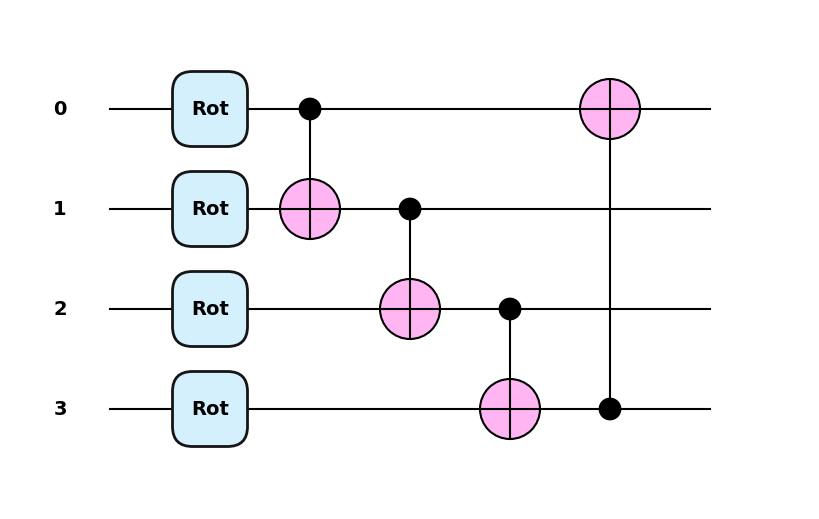

In [3]:
layer_weights = 0.01 * np.random.randn(4,3, requires_grad=True)
wires = [i for i in range(4)]
qml.draw_mpl(layer,style='pennylane')(layer_weights,wires)

Now we need to encode our classic data into circuit. This part is called state preparation. We use [BasisState](https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisState.html).
We parametrize wires depending on the length of X.

In [9]:
def state_preparation(x,wires):
    BasisEmbedding(x, wires=wires)

Now, we define the variational quantum circuit, where `state_preparation` initializes the quantum state based on input data, `weights` parameterize the quantum gates or operations in each layer, and the expectation value calculation provides a measure of the circuit's performance or output.
For the Pauli-Z observable:
- The eigenstate corresponding to the eigenvalue \( +1 \) is $|0\rangle$ (the qubit is in the state 0).
- The eigenstate corresponding to the eigenvalue \( -1 \) is $|1\rangle$ (the qubit is in the state 1).

In [10]:
@qml.qnode(dev)
def circuit(weights, x):
    wires = [i for i in range(len(x))]
    # Step 1: Encode the classical data into a quantum state (state preparation)
    state_preparation(x,wires)
    #  Step 2: Apply a parameterized model (ansatz)
    for layer_weights in weights:
        layer(layer_weights, wires)
    #Step 3: Measure the circuit to extract labels
    return qml.expval(qml.PauliZ(0))


In [11]:
num_layers=2
num_qubits=4
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
circuit(weights_init,X_train[0])

tensor(-0.99960961, requires_grad=True)


Incorporating a bias parameter ensures that our ansatz is more versatile and capable of handling a wider range of data distributions. This leads to better performance and more accurate predictions. The bias term allows the model to shift the decision boundary without relying solely on the weighted inputs, giving the classifier more flexibility in fitting the data.

In [12]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

<a id="4"></a>
## Training
<a id="5"></a>
### Cost function

The provided code defines two functions: `square_loss` and `cost`.
**Loss function**
The loss function is a key component of any machine learning model. It quantifies the error between the predicted values and the actual values (labels). The goal of training is to minimize this loss function. The `square_loss` function implements the **Mean Squared Error (MSE)** loss. MSE is commonly used in regression tasks to measure the average squared difference between the predicted values and the actual values. The formula for MSE is:
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

where $y_i$ are the actual labels, $\hat{y}_i$ are the predicted values, and $n$ is the number of samples.

**Cost function**
The cost function aggregates the loss over the entire dataset. In this context, it uses the variational quantum classifier to make predictions for each data point, computes the loss for each prediction, and then averages these losses to get the overall cost.


In [13]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)


The goal of these functions is to provide a quantitative measure of how well the variational quantum classifier is performing, which we can use to adjust the parameters (weights and biases) of the model to improve its metrics.

<a id="6"></a>
### Optimization
The small initial weight values are chosen to ensure that the training process starts smoothly and avoids numerical issues that could arise from very large or very small initial weights. This practice is based on empirical findings that suggest models train more effectively when starting with small random weights.
In our implementation, we can choose different optimizers. This is certainly useful when the training dataset is larger.

In [2]:
from modules.training import circuit_training
import pennylane.numpy as np
from modules.utils import load_data_4_qubit
X_train, Y_train, X_test,Y_test = load_data_4_qubit()


num_qubits = 4
num_layers = 2
learning_rate= 0.5
batch_size = 5
num_epochs = 100

#Step 4: Use optimization techniques (like gradient descent) to update model parameter (classical part)
weights, costs, train_accuracies, val_accuracies, biases = circuit_training(X_train,Y_train,X_test,Y_test, num_qubits, num_layers,learning_rate,batch_size,num_epochs,seed = 0)

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1
Epoch: 0 | Cost: 2.5544335 | Acc train: 0.2000000 | Acc validation: 0.5000000
Epoch: 1 | Cost: 0.6238259 | Acc train: 0.8000000 | Acc validation: 0.5000000
Epoch: 2 | Cost: 0.0014369 | Acc train: 1.0000000 | Acc validation: 0.5000000
Epoch: 3 | Cost: 0.7734843 | Acc train: 0.6000000 | Acc validation: 0.5000000
Epoch: 4 | Cost: 0.9509335 | Acc train: 0.6000000 | Acc validation: 0.3333333
Epoch: 5 | Cost: 0.7933134 | Acc train: 0.8000000 | Acc validation: 0.5000000
Epoch: 6 | Cost: 0.0536897 | Acc train: 1.0000000 | Acc validation: 0.6666667
Epoch: 7 | Cost: 1.0374944 | Acc train: 0.8000000 | Acc validation: 0.6666667
Epoch: 8 | Cost: 0.0873381 | Acc train: 1.0000000 | Acc validation: 0.3333333
Epoch: 9 | Cost: 0.6576230 | Acc train: 0.8000000 | Acc validation: 0.3333333
Epoch:

<a id="7"></a>
## Metrics
1. **Accuracy**
Accuracy is a measure of how often the classifier makes correct predictions. It is defined as the ratio of correctly predicted instances to the total instances. Mathematically, it is expressed as:
$$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$
2. **Precision**
Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is an important metric when the cost of false positives is high.
$$\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}$$
,where: $\text{TP = True Positives}$,$\text{FP = False Positives}$

3. **Recall**
Recall (also known as Sensitivity) is the ratio of correctly predicted positive observations to all observations in the actual class. It is important when the cost of false negatives is high.
$$\text{Recall} = \frac{\text{TP}}{\text{TP}+\text{FN}}$$
4. **F1 Score**
F1 Score is the harmonic mean of precision and recall. It is a balance between precision and recall and is useful when the distribution between positive and negative classes is uneven.
$$\text{F1 Score} = 2*\frac{\text{Precision}* \text{Recall}}{\text{Precision}+\text{Recall}}$$

5. **Area Under the Receiver Operating Characteristic Curve (ROC AUC)**
AUC-ROC measures the ability of the classifier to distinguish between classes. The ROC curve is a plot of the true positive rate (recall) against the false positive rate (FPR) at various threshold settings.


Accuracy: 1.0 | Precision: 1.0 | Recall: 1.0 | F1 Score: 1.0 | AUC-ROC: 1.0


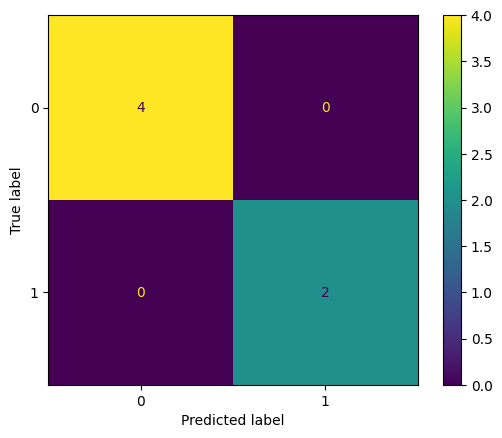

In [3]:
from modules.metrics import show_all_metrics
import pennylane.numpy as np
from modules.training import compute_predictions
bias_init = np.array(0.0, requires_grad=True)

test_predictions = compute_predictions(weights=weights, bias=bias_init, X = X_test, num_qubits=num_qubits, state_prep=None)
show_all_metrics(Y_test,test_predictions)

<a id="8"></a>
## Full code

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane import BasisEmbedding,AmplitudeEmbedding,AngleEmbedding
from modules.metrics import accuracy

dev = qml.device("default.qubit")
def layer(layer_weights, wires):
    qml.broadcast(qml.Rot,wires=wires,pattern='single',parameters=layer_weights)
    qml.broadcast(qml.CNOT, wires=wires, pattern='ring')

def state_preparation(x,wires):
    BasisEmbedding(x, wires=wires)

@qml.qnode(dev)
def circuit(weights, x):
    wires = [i for i in range(len(x))]

    state_preparation(x,wires)

    for layer_weights in weights:
        layer(layer_weights, wires)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

from modules.utils import load_data_4_qubit
X_train, Y_train, X_test,Y_test = load_data_4_qubit()

np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_batch]

    current_cost = cost(weights, bias, X_batch, Y_batch)
    acc = accuracy(Y_batch, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")